In [1]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

from dynamics import Ball, Plate, LinearModel
from controller import MPC

In [2]:
dt = 0.1 # s, discrete time step
mu = 0.2 # Dry Coulomb friction constant plastic-plastic: 0.2-0.4
g = 9.81 # m/s^2, gravitational acceleration
N = 15 # prediction horizon

m_ball = 1e-2 # kg
r_ball = 5e-3 # m

m_plate = 0.1 # kg
l_plate = 0.3 # m

v_max = np.array([2.0, 2.0]) # m/s
w_max = np.array([3.0, 3.0]) # rad/s
Tmax = 0.05 # Nm
rmax = 0.1 # m

# plate = Plate(m_plate, l_plate)
# ball = Ball(m_ball, r_ball, mu, g)
system = LinearModel(dt, m_ball, g, l_plate, v_max, w_max, Tmax, rmax)
controller = MPC(system, dt, N)

In [3]:
# # fig = plt.figure()
# # ax = fig.add_subplot(projection='3d')
# # plt.show()

# x = np.linspace(0, 2*np.pi, 100)
# y = np.sin(x)

# fig, ax = plt.subplots()
# line, = ax.plot([])   # A tuple unpacking to unpack the only plot

# ax.set_xlim(0, 2*np.pi)
# ax.set_ylim(-1.1, 1.1)

# def animate(frame_num):
#     y = np.sin(x + 2*np.pi * frame_num/100)
#     line.set_data((x, y))
#     return line
# anim = FuncAnimation(fig, animate, frames=100, interval=20)

# display.display(display.HTML(anim.to_html5_video()))
# plt.close()                   # avoid plotting a spare static plot

In [4]:
# # Trajectory for the ball.
# R = l_plate / (2 * 10 * np.pi)

# fig, ax = plt.subplots()
# line, = ax.plot([])   # A tuple unpacking to unpack the only plot

# ax.set_xlim([-l_plate/2.0, l_plate/2.0])
# ax.set_ylim([-l_plate/2.0, l_plate/2.0])
# ax.vlines(0, ymin=-l_plate/2.0, ymax=l_plate/2.0, linestyles='dashed', colors='gray', alpha=0.5)
# ax.hlines(0, xmin=-l_plate/2.0, xmax=l_plate/2.0, linestyles='dashed', colors='gray', alpha=0.5)

# def animate(frame_num):
#     T = frame_num * 8*np.pi / 100
#     t = np.linspace(0, T, frame_num)
#     x = R * (8*np.pi - t) * np.cos(-t + 3 * np.pi/4.0)
#     y = R * (8*np.pi - t) * np.sin(-t + 3 * np.pi/4.0)
#     line.set_data((x, y))
#     return line

# anim = FuncAnimation(fig, animate, frames=100, interval=40)
# display.display(display.HTML(anim.to_html5_video()))
# plt.close()

In [5]:
# Test system dynamics
fig, ax = plt.subplots()
line, = ax.plot([])   # A tuple unpacking to unpack the only plot

no_frames = 100
ax.set_xlim([-l_plate/2.0, l_plate/2.0])
ax.set_ylim([-l_plate/2.0, l_plate/2.0])
ax.vlines(0, ymin=-l_plate/2.0, ymax=l_plate/2.0, linestyles='dashed', colors='gray', alpha=0.5)
ax.hlines(0, xmin=-l_plate/2.0, xmax=l_plate/2.0, linestyles='dashed', colors='gray', alpha=0.5)

u = np.zeros((no_frames-1, system._NO_OF_INPUTS))
u[0] = np.array([1e-13, 0., 0., -1e-13])
# u[5] = np.array([0., 0., 0., -1e-13])

def animate(frame_num):
    y = np.zeros((frame_num, system._NO_OF_OUTPUTS))
    x = np.zeros((system._NO_OF_STATES,))
    # u = np.zeros((frame_num+1, system._NO_OF_INPUTS))
    # u[0] = np.array([0., 1e-2, 0., 0.])

    for k in range(frame_num-1):
        x = system.update(x, u[k])
        y[k+1] = system.get_output(x)

    line.set_data((y[:,0], y[:,1]))
    return line

anim = FuncAnimation(fig, animate, frames=no_frames, interval=100)
display.display(display.HTML(anim.to_html5_video()))
plt.close()

Why does the ball keep going towards the bottom-left?

Status: infeasible


AssertionError: No feasible solution is found.

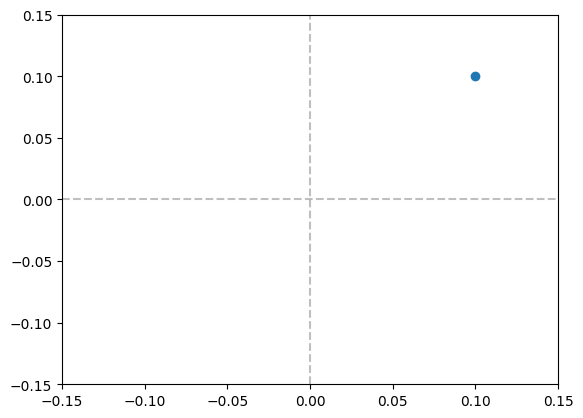

In [28]:
# Test system dynamics
fig, ax = plt.subplots()
line, = ax.plot([], 'o-')   # A tuple unpacking to unpack the only plot

y_init = np.array([0.1, 0.1])
x_init = np.zeros((system._NO_OF_STATES))
x_init[0] = y_init[0]
x_init[2] = y_init[1]
x_target = np.zeros((system._NO_OF_STATES))

no_frames = 25
ax.set_xlim([-l_plate/2.0, l_plate/2.0])
ax.set_ylim([-l_plate/2.0, l_plate/2.0])
ax.vlines(0, ymin=-l_plate/2.0, ymax=l_plate/2.0, linestyles='dashed', colors='gray', alpha=0.5)
ax.hlines(0, xmin=-l_plate/2.0, xmax=l_plate/2.0, linestyles='dashed', colors='gray', alpha=0.5)

U = []
Y = np.zeros((no_frames, system._NO_OF_STATES))

def animate(frame_num):
    y = np.vstack((y_init, np.zeros((frame_num, system._NO_OF_OUTPUTS))))
    x = np.zeros((system._NO_OF_STATES,))

    for k in range(frame_num-1):
        u, x, _, _ = controller.predict(x_init, x_target)
        y[k+1] = system.get_output(x)
        U.append(u)

    Y = y
    line.set_data((y[:,0], y[:,1]))
    return line

anim = FuncAnimation(fig, animate, frames=no_frames, interval=100)
display.display(display.HTML(anim.to_html5_video()))
plt.close()

In [13]:
U = np.array(U)
print(U)
print(Y)

[[-0.00099091  0.00099091 -0.00099091  0.00099091]
 [-0.00099091  0.00099091 -0.00099091  0.00099091]
 [-0.00099091  0.00099091 -0.00099091  0.00099091]
 ...
 [-0.00099091  0.00099091 -0.00099091  0.00099091]
 [-0.00099091  0.00099091 -0.00099091  0.00099091]
 [-0.00099091  0.00099091 -0.00099091  0.00099091]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
